### Topic Modeling

In [65]:
import pandas as pd
import nltk
import json
import numpy as np
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
import string
import spacy
import en_core_web_sm
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Word2Vec
import pprint
from operator import itemgetter

from sklearn import cluster
from sklearn import metrics

import seaborn
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from Data_Processor import clean, Data_Processor

In [19]:
DP=Data_Processor(start_month='2017-01',end_month='2020-05',template="./Data/Wealth_Management")
month_id = []

In [20]:
raw_data = {}
for year in ['2017','2018','2019', '2020']:
    for i in range(1,13):
        template = "Wealth_Management"+year+"-"
        month = '0'+str(i) if(i<10) else str(i)
        month_id.append(year+month)
        if year=='2020' and i>5:
            break
        filename = template + month + '.json'
        with open(filename) as f_in:
            file = json.load(f_in)
        text = [t['text'] for t in file]
        raw_data[year+month] = raw_data.get(year+month,[]) + text

In [6]:
data = raw_data.copy()
len(data['201712'])

9354

In [7]:
token_data = {}
string_data = {}

#### Data clean

In [193]:
for k in data:
    data[k] = clean(data[k])
    token_data[k] = []
    string_data[k] = []
    for sent in data[k]:
        token_data[k].append(DP.getngrams(data=sent,num=1,lemma=True))
        string_data[k].append(" ".join(token_data[k][-1]))

In [11]:
print(token_data['202005'][0])
print(string_data['202005'][0])

['like', 'people', 'sort', 'moral', 'compass', 'work', 'big', 'bank', 'tech', 'company', 'like', 'google', 'apple', 'facebook', 'feel', 'gross', 'unethical', 'iphone', 'bank', 'account', 'yall', 'sleep', 'night']
like people sort moral compass work big bank tech company like google apple facebook feel gross unethical iphone bank account yall sleep night


In [84]:
#save token data and string data
with open('token_data.txt','w') as file:
     file.write(json.dumps(token_data)) # use `json.loads` to do the reverse
with open('string_data.txt','w') as file:
     file.write(json.dumps(string_data)) # use `json.loads` to do the reverse

In [96]:
spacy_nlp = en_core_web_sm.load()
extract_words = {}

# Part-of-speech tagging (here extract nones)
def pos_tagging(data):
    req_tag = ['NN']
    list_words = []
    try:
        for x in data:
            doc = spacy_nlp(x)
            words = []
            for token in doc:
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    words.append(token.lemma_)
            if words:
                list_words.append(words)
        return list_words
    except Exception as e:
        return list_words

In [97]:
for k in string_data:
    print("pos tagging",k)
    extract_words[k] = pos_tagging(string_data[k])

pos tagging 201701
pos tagging 201702
pos tagging 201703
pos tagging 201704
pos tagging 201705
pos tagging 201706
pos tagging 201707
pos tagging 201708
pos tagging 201709
pos tagging 201710
pos tagging 201711
pos tagging 201712
pos tagging 201801
pos tagging 201802
pos tagging 201803
pos tagging 201804
pos tagging 201805
pos tagging 201806
pos tagging 201807
pos tagging 201808
pos tagging 201809
pos tagging 201810
pos tagging 201811
pos tagging 201812
pos tagging 201901
pos tagging 201902
pos tagging 201903
pos tagging 201904
pos tagging 201905
pos tagging 201906
pos tagging 201907
pos tagging 201908
pos tagging 201909
pos tagging 201910
pos tagging 201911
pos tagging 201912
pos tagging 202001
pos tagging 202002
pos tagging 202003
pos tagging 202004
pos tagging 202005


In [98]:
with open('extract_words.txt','w') as file:
     file.write(json.dumps(extract_words)) # use `json.loads` to do the reverse

### Method 1: LDA

In [99]:
lda = {}
def LDA(texts,topics=10,num_words=15):
    dictionary = corpora.Dictionary(texts) # texts: list of list of words
    corpus = [dictionary.doc2bow(text) for text in texts]
    num_topics = topics #The number of topics that should be generated
    passes = 20
    lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)
    #pp = pprint.PrettyPrinter(indent=4)
    #pp.pprint(lda.print_topics(num_words=num_words))
    
    # correlation between a tweet and each topic
    #pp.pprint(sorted(lda.get_document_topics(corpus[0],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True))
    return lda

In [ ]:
for k in extract_words:
    print("lda modeling", k)
    lda[k] = LDA(extract_words[k], topics=10, num_words=15)

In [101]:
## save the model
for k in lda:
    lda[k].save('lda_'+k+'.model')

Text(0.5, 0.98, '2020 Feb - E*Trade Acqusition (first row second one)')

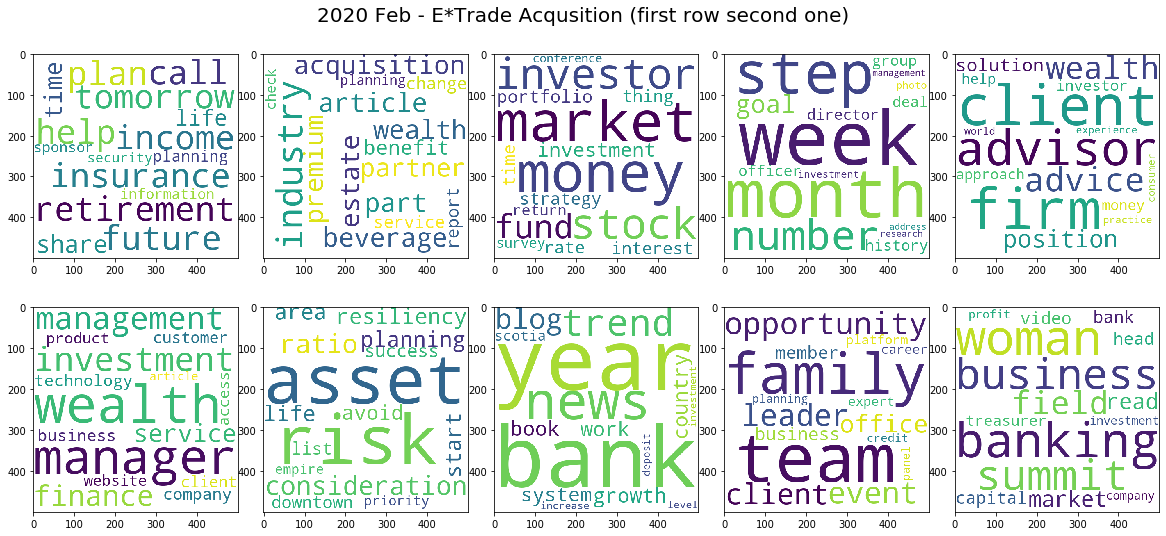

In [268]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))

# topic 2 in 2020 Feb
for i in range(10):
    k = '202002'
    topic = " ".join([w for w,p in lda[k].show_topic(i, 15)])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    fig.tight_layout(pad = 0) 

fig.suptitle("2020 Feb - E*Trade Acqusition (first row second one)", fontsize=20)

Text(0.5, 0.98, '2020 April - Coronavirus, Crisis (first & second row fourth one)')

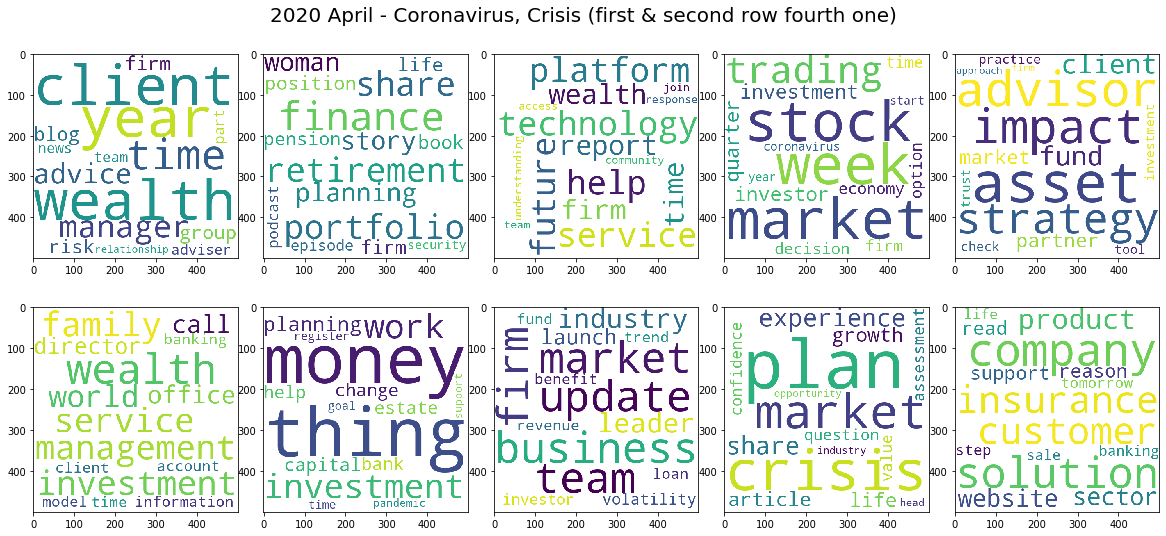

In [267]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '202004'
    topic = " ".join([w for w,p in lda[k].show_topic(i, 15)])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
fig.suptitle("2020 April - Coronavirus, Crisis (first & second row fourth one)", fontsize=20)

In [138]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda['202004'].print_topics(num_words=15))

[   (   0,
        '0.094*"client" + 0.040*"wealth" + 0.038*"year" + 0.035*"time" + '
        '0.028*"manager" + 0.024*"advice" + 0.022*"group" + 0.017*"blog" + '
        '0.016*"firm" + 0.016*"risk" + 0.015*"adviser" + 0.015*"part" + '
        '0.015*"team" + 0.014*"news" + 0.011*"relationship"'),
    (   1,
        '0.072*"finance" + 0.069*"retirement" + 0.059*"portfolio" + '
        '0.046*"share" + 0.039*"planning" + 0.026*"woman" + 0.024*"story" + '
        '0.021*"position" + 0.015*"book" + 0.015*"firm" + 0.015*"life" + '
        '0.015*"pension" + 0.014*"episode" + 0.014*"podcast" + '
        '0.013*"security"'),
    (   2,
        '0.080*"technology" + 0.062*"platform" + 0.052*"help" + 0.025*"future" '
        '+ 0.023*"service" + 0.021*"report" + 0.020*"firm" + 0.019*"wealth" + '
        '0.013*"time" + 0.013*"response" + 0.013*"team" + 0.012*"community" + '
        '0.012*"join" + 0.012*"access" + 0.011*"understanding"'),
    (   3,
        '0.077*"market" + 0.057*"stock" + 0

Text(0.5, 0.98, '2020 May - Return, Recovery (second row fourth one)')

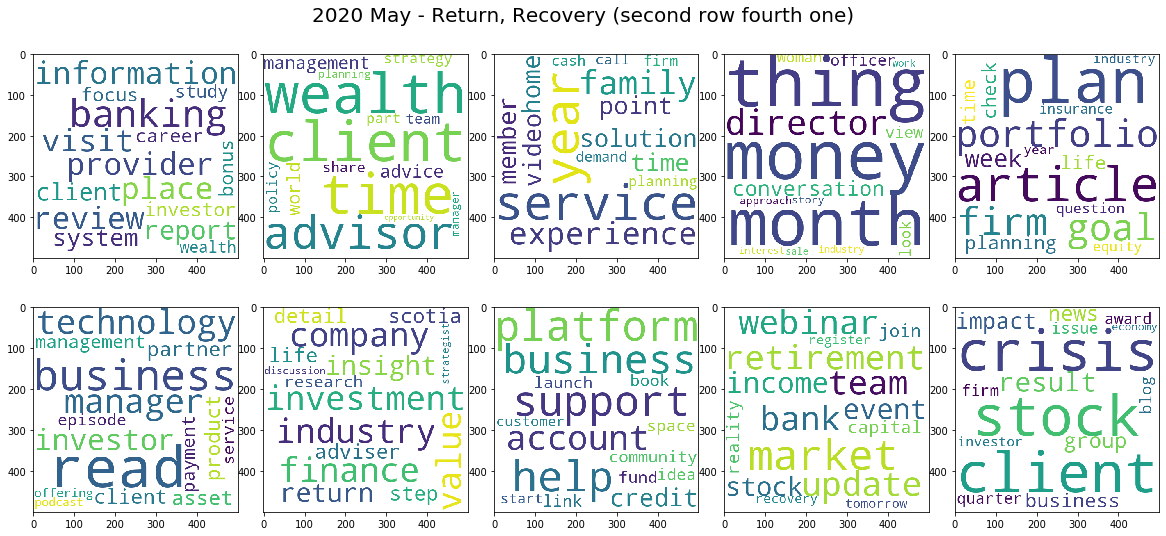

In [266]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '202005'
    topic = " ".join([w for w,p in lda[k].show_topic(i, 15)])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
fig.suptitle("2020 May - Return, Recovery (second row fourth one)", fontsize=20)

### Method 2 Non-negative Natrix Factorization (NMF)

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
stop = set(stopwords.words('english'))
stop.update(('http','llc','inc', 'twitter', 'tweet'))

doc_term_matrix = {}
tfidf_vect = {}
nmf = {}

In [259]:
for k in string_data:
    tfidf_vect[k] = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=stop)
    doc_term_matrix[k] = tfidf_vect[k].fit_transform(string_data[k])
    nmf[k] = NMF(n_components=10, random_state=42)
    nmf[k].fit(doc_term_matrix[k])

Text(0.5, 0.98, '2019 Sep - Brokerdealers Price War (second row first one)')

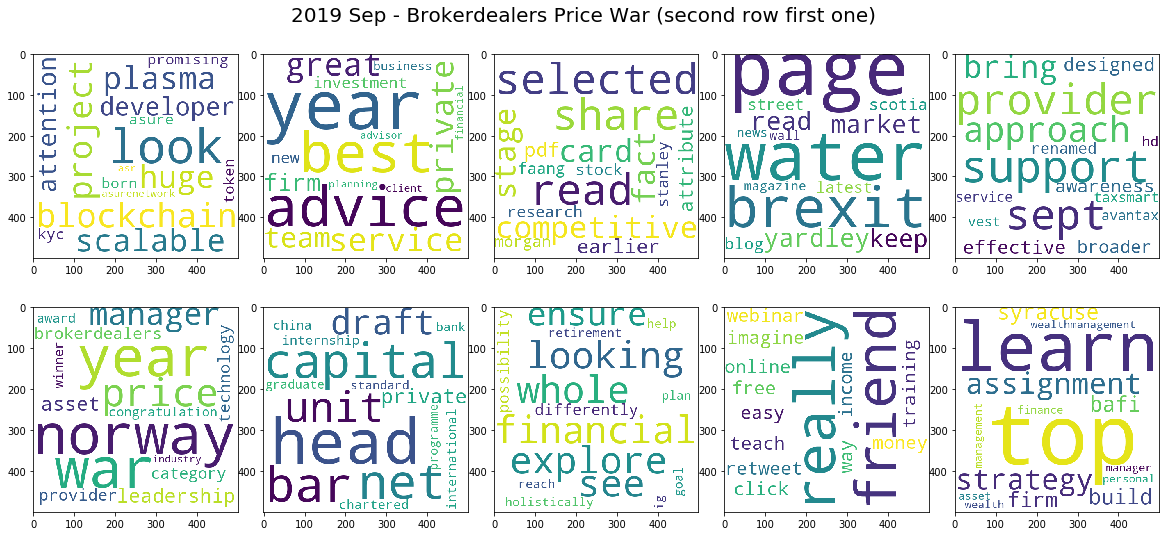

In [263]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '201909'
    topic = " ".join([tfidf_vect[k].get_feature_names()[i] for i in nmf[k].components_[i].argsort()[-15:]])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2019 Sep - Brokerdealers Price War (second row first one)", fontsize=20)

Text(0.5, 0.98, '2019 Nov - Charles Schwab to Acquire TD Ameritrade (first row last one)')

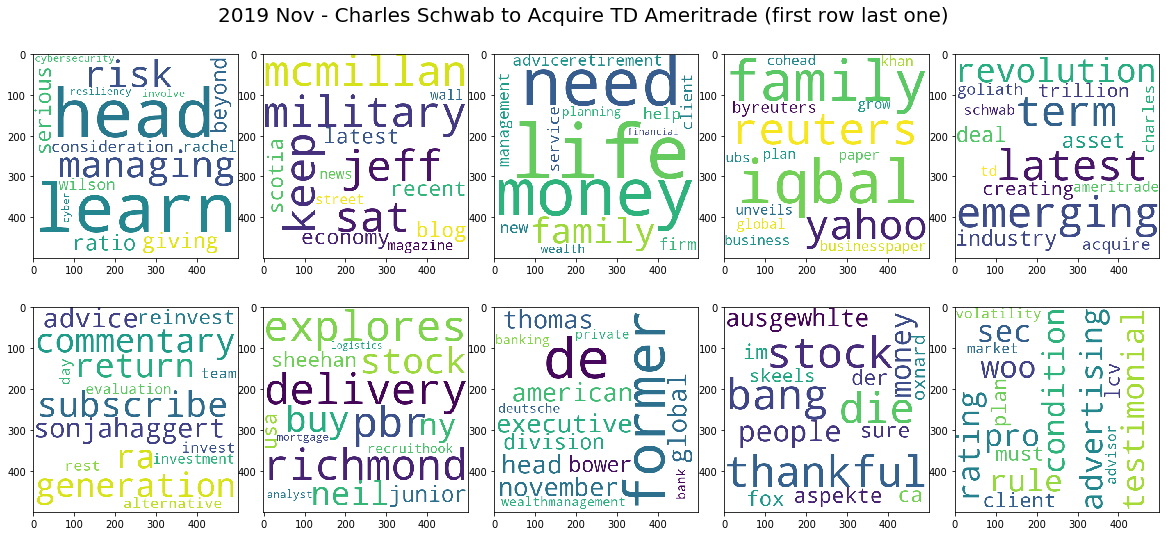

In [262]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '201911'
    topic = " ".join([tfidf_vect[k].get_feature_names()[i] for i in nmf[k].components_[i].argsort()[-15:]])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2019 Nov - Charles Schwab to Acquire TD Ameritrade (first row last one)", fontsize=20)

#Goldman Sachs to buy boutique wealth management custodian Folio

Text(0.5, 0.98, '2020 Feb - Morgan Stanley to Acquire E-trade (second row second one), Cybersecurity Conference')

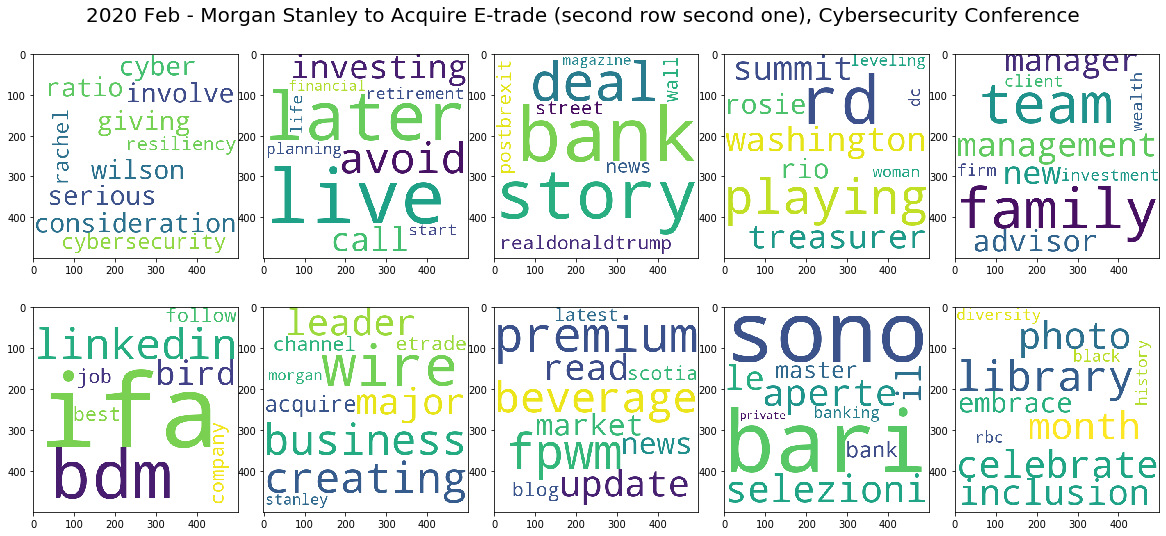

In [264]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '202002'
    topic = " ".join([tfidf_vect[k].get_feature_names()[i] for i in nmf[k].components_[i].argsort()[-10:]])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2020 Feb - Morgan Stanley to Acquire E-trade (second row second one), Cybersecurity Conference", fontsize=20)

Text(0.5, 0.98, '2020 May - Pandemic, Space, Goldman Sachs to Buy Folio (second row first one)')

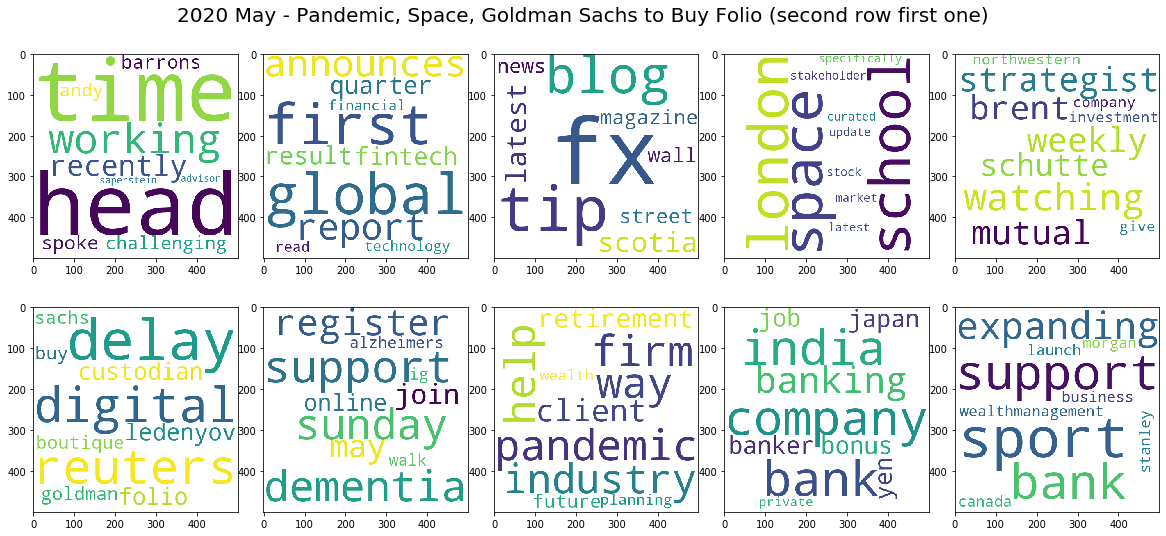

In [265]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
i = 0
for i in range(10):
    k = '202005'
    topic = " ".join([tfidf_vect[k].get_feature_names()[i] for i in nmf[k].components_[i].argsort()[-10:]])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2020 May - Pandemic, Space, Goldman Sachs to Buy Folio (second row first one)", fontsize=20)

#Goldman Sachs to buy boutique wealth management custodian Folio

In [200]:
k = '202005'
for i,topic in enumerate(nmf[k].components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect[k].get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['time', 'head', 'working', 'recently', 'spoke', 'barrons', 'challenging', 'andy', 'saperstein', 'advisor']


Top 10 words for topic #1:
['global', 'first', 'announces', 'report', 'quarter', 'fintech', 'result', 'technology', 'financial', 'read']


Top 10 words for topic #2:
['fx', 'tip', 'blog', 'scotia', 'latest', 'since', 'magazine', 'street', 'wall', 'news']


Top 10 words for topic #3:
['school', 'london', 'space', 'specifically', 'curated', 'stakeholder', 'latest', 'stock', 'update', 'market']


Top 10 words for topic #4:
['watching', 'strategist', 'weekly', 'mutual', 'brent', 'schutte', 'northwestern', 'give', 'company', 'investment']


Top 10 words for topic #5:
['delay', 'digital', 'reuters', 'ledenyov', 'custodian', 'folio', 'boutique', 'sachs', 'buy', 'goldman']


Top 10 words for topic #6:
['support', 'dementia', 'sunday', 'register', 'may', 'join', 'online', 'alzheimers', 'ig', 'walk']


Top 10 words for topic #7:
['pandemic', 'help', 'firm', 'wa

### Method 3  Clustering (K-means)

1. #### Word2Vec Embedding

In [269]:
word2vec_model = {}
word_vectors = {}
cluster_words = {}

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [221]:
k = '202005'
word2vec_model[k] = Word2Vec(token_data[k], min_count = 1, size=32)
word_vectors[k] = word2vec_model[k].wv.syn0
num_clusters = 10

# Initalize a k-means object and use it to extract centroids

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors[k])

word_centroid_map = dict(zip(word2vec_model[k].wv.index2word, idx))

for cluster in range(10):
    # Print the cluster number
    # print("\nCluster %d" % cluster)
    # Find all of the words for that cluster number, and print them out
    
    nlen = len(word_centroid_map)
    keys = list(word_centroid_map.keys())
    values = list(word_centroid_map.values())
    for i in range(nlen):
        if(values[i] == cluster):
            cluster_words[cluster] = cluster_words.get(cluster,"") + " " + keys[i]


C:\Users\hwk97\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


Text(0.5, 0.98, '2020 May')

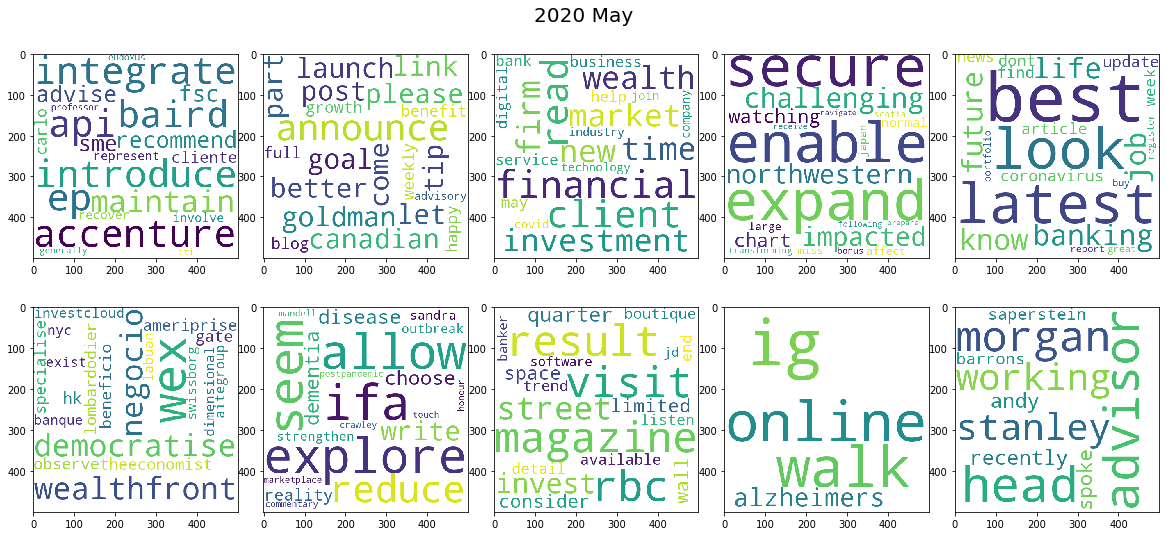

In [255]:
fig, axs = plt.subplots(2,5, figsize = (16, 8))
for i in range(10):
    topic = cluster_words[i]
    #" ".join([tfidf_vect[k].get_feature_names()[i] for i in nmf[k].components_[i].argsort()[-10:]])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', max_words=20,
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2020 May", fontsize=20)

#### 2. TF-IDF Embedding

In [283]:
tfidf_vect = {}
tfidf = {}
kmeans_tfidf = {}

In [284]:
for k in string_data:
    tfidf_vect[k] = TfidfVectorizer(stop_words=stop)
    tfidf[k] = tfidf_vect[k].fit_transform(string_data[k])
    # k-means fit
    kmeans_tfidf[k] = KMeans(n_clusters=20).fit(tfidf[k])

#kmeans = KMeans(n_clusters = 10)
#idx = kmeans.fit_predict(tfidf)

Text(0.5, 0, 'frequencey')

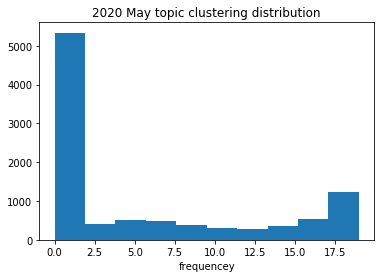

In [290]:
plt.title("2020 May topic clustering distribution")
plt.hist(kmeans_tfidf[k].labels_)
plt.xlabel('topic')
plt.xlabel('frequencey')

In [305]:
cluster_words = {}

for i in set(kmeans_tfidf[k].labels_):
    current_cluster = [string_data[k][x] for x in np.where(kmeans_tfidf[k].labels_ == i)[0]]
    cluster_words[i] = list(set(current_cluster))

Text(0.5, 0.98, '2020 May')

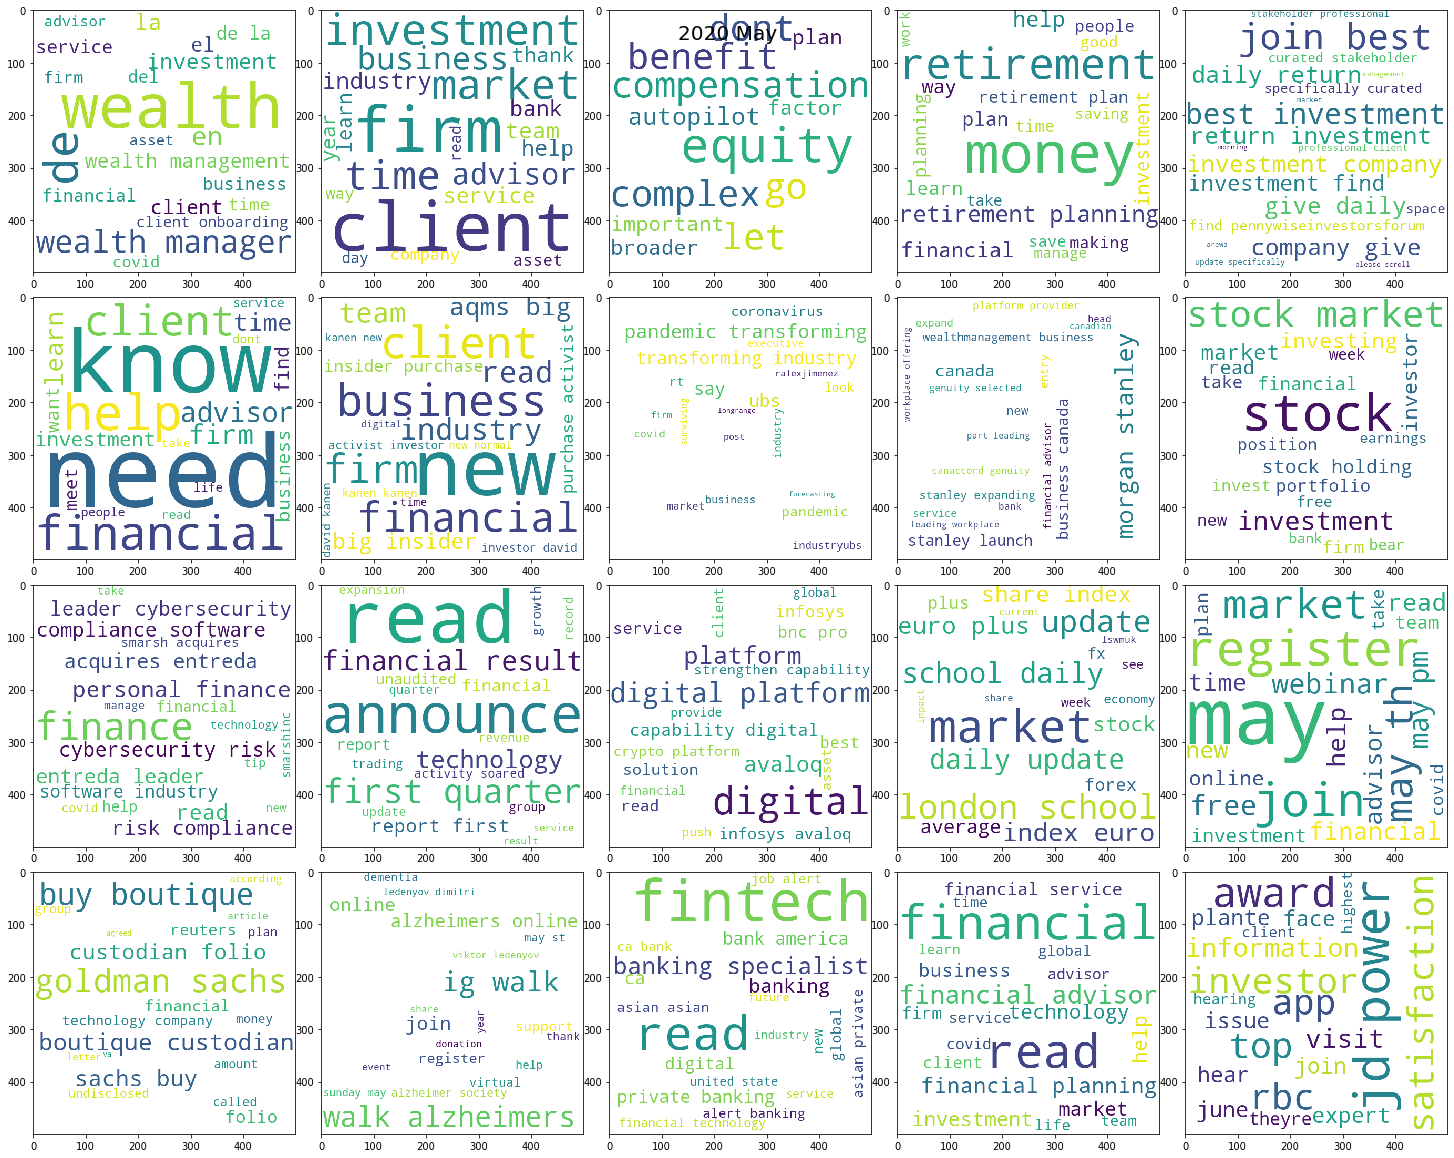

In [312]:
fig, axs = plt.subplots(4,5, figsize = (20, 16))
for i in range(20):
    topic = " ".join(cluster_words[i])
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', max_words=20,
                min_font_size = 10).generate(topic) 
    # plot the WordCloud image                        
    axs[i//5][i%5].imshow(wordcloud) 
    
    fig.tight_layout(pad = 0) 
    
fig.suptitle("2020 May", fontsize=20)

In [108]:
kmeans_tfidf[k].cluster_centers_

array([[5.91323141e-06, 5.20580812e-06, 9.80360177e-06, ...,
        0.00000000e+00, 1.86203222e-05, 7.04647045e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.69845637e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50171929e-05, 9.82895714e-06, 0.00000000e+00, ...,
        3.48753545e-05, 0.00000000e+00, 1.50507053e-05]])

In [ ]:
## Use  t-SNE to visualize

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
n = 10
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfidf[k])
tfs_embedded = TSNE(n_components=5, perplexity=40, verbose=2).fit_transform(tfs_reduced)

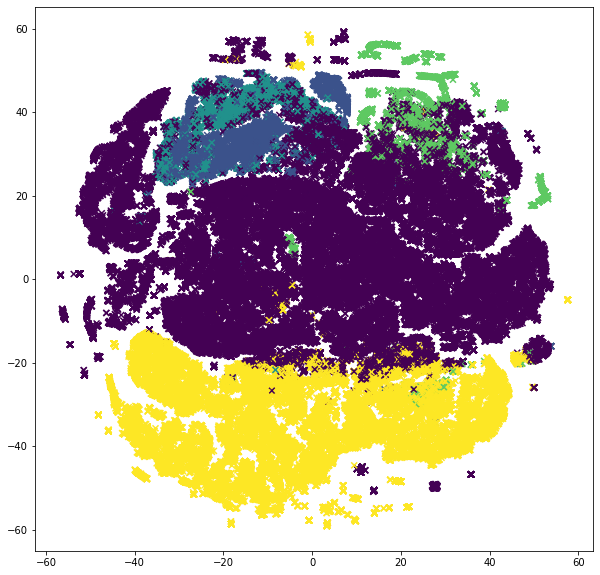

In [101]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = kmeans.labels_)
plt.show()